# Coresets with DPPs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

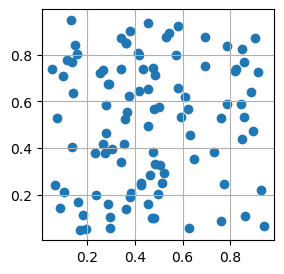

In [3]:
n, d = 100, 2
X = 0.9*(np.random.rand(n, d) - .5) + .5

plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:,1])
plt.grid(), plt.show();

## Gaussian kernel vs. Bernoulli process

In [8]:
def gauss(sigma):
    def kernel(tau):
        return np.exp(-np.sum(tau**2, axis=-1)/sigma**2)
    return kernel

def KernelMatrix(x,y,h):
    return h(x[:,None]-y[None,:])

K = KernelMatrix(X,X,gauss(2))
print(f"first 5 cols,rows:\n{K[:5,:5]}")

first 5 cols,rows:
[[1.         0.63200696 0.85497218 0.73575437 0.53938662]
 [0.63200696 1.         0.58766496 0.90798547 0.62209617]
 [0.85497218 0.58766496 1.         0.54969033 0.80885451]
 [0.73575437 0.90798547 0.54969033 1.         0.44457193]
 [0.53938662 0.62209617 0.80885451 0.44457193 1.        ]]


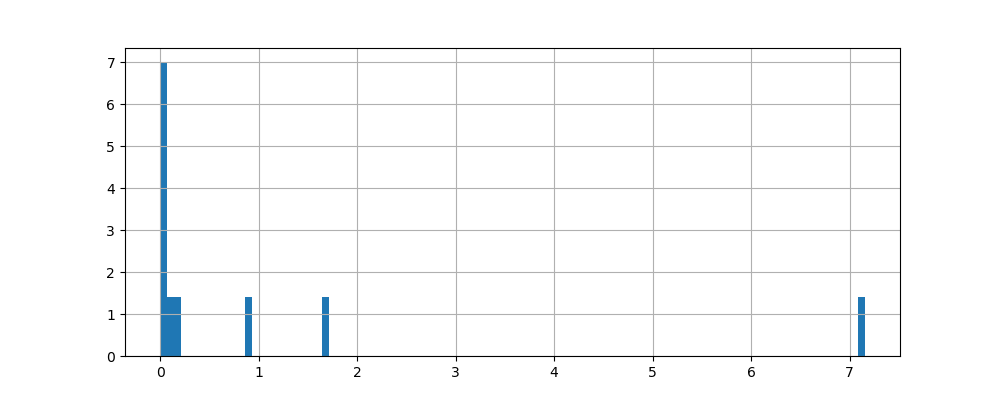

In [9]:
w, v = np.linalg.eigh(K)
    
plt.figure(figsize=(10,4))
plt.hist(w,100, density=True)
plt.grid();

(100, 100)


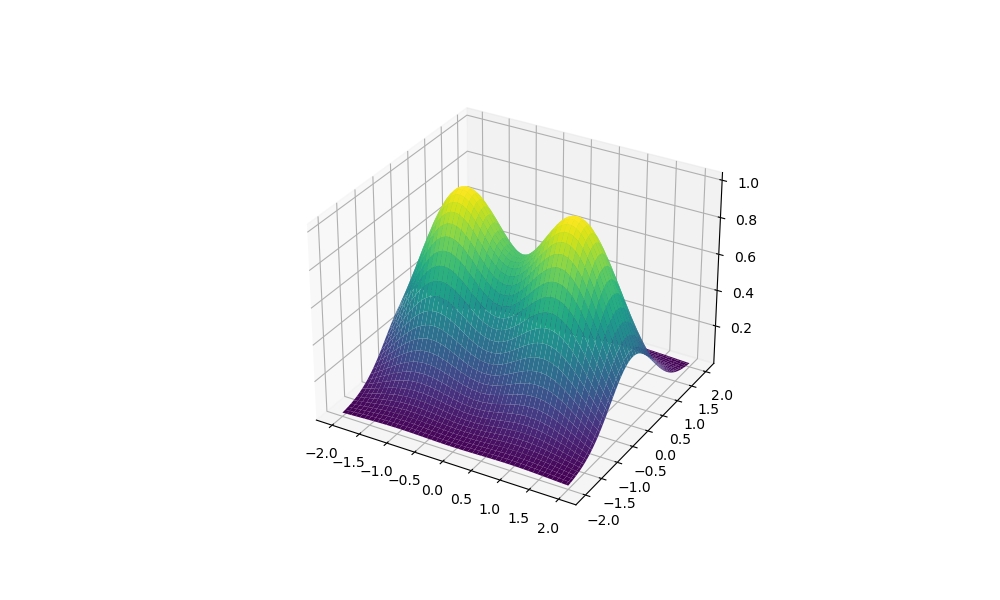

In [10]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

nb_discr = 100
x, y = np.linspace(-2, 2, nb_discr), np.linspace(-2, 2, nb_discr)
xx, yy = np.meshgrid(x, y)
xy = np.array([xx, yy]).transpose(1,2,0)

mu_1 = [-1,0]
mu_2 = [1,0]
C = 0.5
zz = np.exp( -np.sum((xy - mu_1)**2, axis=-1)/(2*C)) + np.exp( -np.sum((xy - mu_2)**2, axis=-1)/(2*C))
print(zz.shape)

surf = ax.plot_surface(xx, yy, zz, cmap="viridis")
plt.show()

## Samplers

### OPE kernel

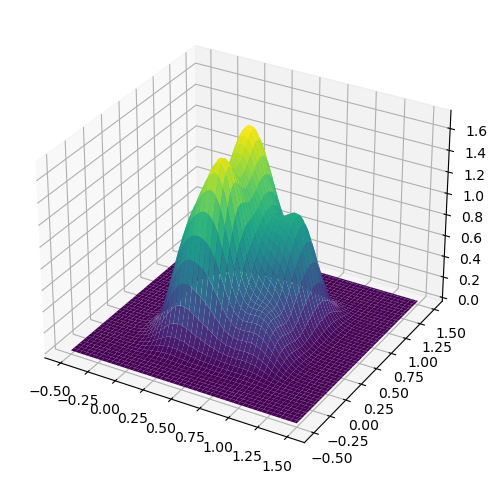

In [4]:
import scipy.stats as stats
gamma_tilde = stats.gaussian_kde(X.T)
gamma_tilde_X = gamma_tilde.pdf(X.T)

plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
nb_discr = 100
cube_halfsize = 1
cube_center = .5
x, y = np.linspace(cube_center-cube_halfsize, cube_center+cube_halfsize, nb_discr), np.linspace(cube_center-cube_halfsize, cube_center+cube_halfsize, nb_discr)
xx, yy = np.meshgrid(x, y)
xy = np.array([xx, yy]).transpose(1,2,0)
zz =  gamma_tilde.pdf(xy.reshape(-1,2).T).T
surf = ax.plot_surface(xx, yy, zz.reshape(100,100), cmap="viridis")
plt.show();

In [65]:
from dppy.multivariate_jacobi_ope import MultivariateJacobiOPE
from dppy.finite_dpps import FiniteDPP
from scipy.sparse.linalg import eigsh
from scipy.linalg import svd
import scipy.stats as stats

def get_DPP_kernel(X, m, ab_coeff= -.5):
    # construct gamma tilde KDE estimation
    gamma_tilde = stats.gaussian_kde(X.T)
    gamma_tilde_X = gamma_tilde.pdf(X.T)
    # obtain P which decompose continuous DPP K = PP^T
    ab_coeff_array = np.zeros((2,2)) + ab_coeff
    dpp = MultivariateJacobiOPE(m, ab_coeff_array)
    polynom_X = dpp.eval_multiD_polynomials(X)
    ref_measure_X = dpp.eval_w(X)
    P = np.sqrt(ref_measure_X / gamma_tilde_X)[:,None] * polynom_X
    # extract m eigenvectors of K by SVD of P
    U, S, Vh = svd(P, full_matrices=False)
    eig_vals, eig_vecs = np.ones(m), U
    diag_K_tilde = (U**2).sum(-1)
    return eig_vals, eig_vecs, diag_K_tilde

def get_DPP_samples(eig_vals, eig_vecs, nb_samples):
    DPP = FiniteDPP(kernel_type='correlation', projection=True, K_eig_dec=(eig_vals, eig_vecs))
    for _ in range(nb_samples):
        DPP.sample_exact(mode='GS')
    return np.array(DPP.list_of_samples)

In [82]:
from dppy.multivariate_jacobi_ope import MultivariateJacobiOPE
from dppy.finite_dpps import FiniteDPP
from scipy.sparse.linalg import eigsh
from scipy.linalg import svd
import scipy.stats as stats
from scipy.sparse.linalg import eigsh

def get_DPP_kernel(X, m, ab_coeff= -.5):
    # construct gamma tilde KDE estimation
    gamma_tilde = stats.gaussian_kde(X.T)
    gamma_tilde_X = gamma_tilde.pdf(X.T)
    # obtain P which decompose continuous DPP K = PP^T
    ab_coeff_array = np.zeros((2,2)) + ab_coeff
    dpp = MultivariateJacobiOPE(m, ab_coeff_array)
    ref_measure_X = dpp.eval_w(X)
    Kq = dpp.K(X, eval_pointwise=False)
    D = np.diag(np.sqrt(np.divide(ref_measure_X, gamma_tilde_X)))
    Ktilde = 1. / n * D @ Kq @ D
    evals_large_sparse, evecs_large_sparse = eigsh(Ktilde, m, which='LM')
    evals_large_sparse = np.ones(m)
    Ktilde = np.dot(evecs_large_sparse,evecs_large_sparse.T)
    diagKtilde = np.diag(Ktilde)
    return evals_large_sparse, evecs_large_sparse, diagKtilde

def get_DPP_samples(eig_vals, eig_vecs, nb_samples):
    DPP = FiniteDPP(kernel_type='correlation', projection=True, K_eig_dec=(eig_vals, eig_vecs))
    for _ in range(nb_samples):
        DPP.sample_exact(mode='GS')
    return np.array(DPP.list_of_samples)

### i.i.d. uniform

In [83]:
def get_uniform_samples(n, m, nb_samples):
    return np.random.choice(n, (nb_samples, m))

### Stratified

In [84]:
from collections import defaultdict

def get_stratified_samples(X, m, nb_samples):
    box_length = m**(-1/d)
    # build stratas
    stratas = defaultdict(list)
    for i_x, x in enumerate(X):
        key = ""
        for dim in range(d):
            key += str(int(x[dim]//box_length))
        stratas[key].append(i_x)
    stratas = np.array(list(stratas.values()), dtype=object)
    nb_stratas = len(stratas)
    # sample from each strata
    strata_samples = np.empty((nb_samples, nb_stratas), dtype=int)
    samples = np.empty((nb_samples, m), dtype=int)
    if nb_stratas<m:
        raise ValueError(f"m={m} but there are only {nb_stratas} stratas. Try increase n")
    for i_strata, strata in enumerate(stratas):
        strata_samples[:,i_strata] = np.random.choice(strata, nb_samples)
    if nb_stratas==m:
        return strata_samples
    # extract m stratas for each samples
    #     for strata in itertools.cycle(stratas):
    for i_strata_sample, strata_sample in enumerate(strata_samples):
        samples[i_strata_sample] = np.random.choice(strata_sample, m, replace=False)
    return samples

### Sampling example

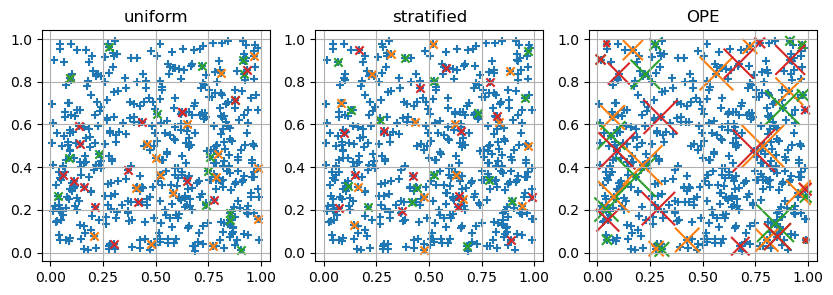

In [85]:
n, m, nb_samples = 500, 16, 3
X = .99*(np.random.rand(n, d) - .5) + .5

uniform_samples = get_uniform_samples(n, m, nb_samples)
X_uniform = X[uniform_samples]
stratified_samples = get_stratified_samples(X, m, nb_samples)
X_stratified = X[stratified_samples]
eig_vals, eig_vecs, diag_K_tilde = get_DPP_kernel(X, m)
DPP_samples = get_DPP_samples(eig_vals, eig_vecs, nb_samples)
X_DPP = X[DPP_samples]
weights_DPP = 1/diag_K_tilde[DPP_samples]

titles = ["uniform","stratified","OPE"]
weights = [None, None, weights_DPP]
plt.figure(figsize=(10,3))
for k, X_samples in enumerate([X_uniform, X_stratified, X_DPP]):
    plt.subplot(1,3,k+1)
    plt.scatter(X[:,0], X[:,1], marker='+')
    for i_sample in range(nb_samples):
        weight = None
        if weights[k] is not None: weight= 10*weights[k][i_sample]
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight)
    plt.title(titles[k]), plt.grid()
    # plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])

## Statistics

### Loss and error

In [86]:
def risk(X):
    return ((X-.5)**2).sum(-1)

def loss(X, samples=None, weights=None):
    if samples is None:
        return risk(X).mean(-1)
    elif weights is None:
        return (risk(X[samples])).mean(-1)
    else:
        return (risk(X[samples]) * weights).sum(-1)

def relative_error(y_hat, y):
    return np.abs(1 - y_hat / y)

### Variance rate

In [87]:
%%time
n = 700 # 1024
nb_rep = 500 # 1000
delta1, delta2 = .1, .01
# ms = np.round(np.logspace(1, 6, num=10, base=2)).astype(int)
# ms = np.arange(2, 12)**2
ms = np.arange(2, 10)**2
print(ms)
X = (np.random.rand(n, d) - .5) + .5
SE_means, SE_stds = [], []
relerr_quant1, relerr_quant2 = [], []
loss_X = loss(X)
eig_vals, eig_vecs, diag_K_tilde = get_DPP_kernel(X, int(ms[-1]))

for m in ms:
    print(f"m={m}")
    # sample
    uniform_samples = get_uniform_samples(n, m, nb_rep)
    loss_uniform = loss(X, uniform_samples)
    stratified_samples = get_stratified_samples(X, m, nb_rep)
    loss_stratified = loss(X, stratified_samples)
    DPP_samples = get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], nb_samples=nb_rep)
    loss_DPP = loss(X, DPP_samples, weights=(diag_K_tilde[DPP_samples])**(-1))
    # loss_DPP2 = loss(X, DPP_samples, weights=(diag_K_tilde[DPP_samples])**(-.5))
    # loss_DPP3 = loss(X, DPP_samples, weights=(diag_K_tilde[DPP_samples])**(0))
    # loss_DPP4 = loss(X, DPP_samples, weights=(diag_K_tilde[DPP_samples])**(.5))
    # loss_samples = np.array([loss_uniform, loss_stratified, loss_DPP, loss_DPP2, loss_DPP3, loss_DPP4])
    loss_samples = np.array([loss_uniform, loss_stratified, loss_DPP])
    # compute metrics
    SEs = (loss_samples - loss_X)**2
    SE_means.append(SEs.mean(-1))
    SE_stds.append(SEs.std(-1))
    relerr = relative_error(loss_samples, loss_X)
    relerr_quant1.append(np.quantile(relerr, delta1, axis=-1))
    relerr_quant2.append(np.quantile(relerr, delta2, axis=-1))
relerr_quant1, relerr_quant2 = np.array(relerr_quant1), np.array(relerr_quant2)
SE_means, SE_stds = np.array(SE_means), np.array(SE_stds)

[ 4  9 16 25 36 49 64 81]
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
Wall time: 16.7 s


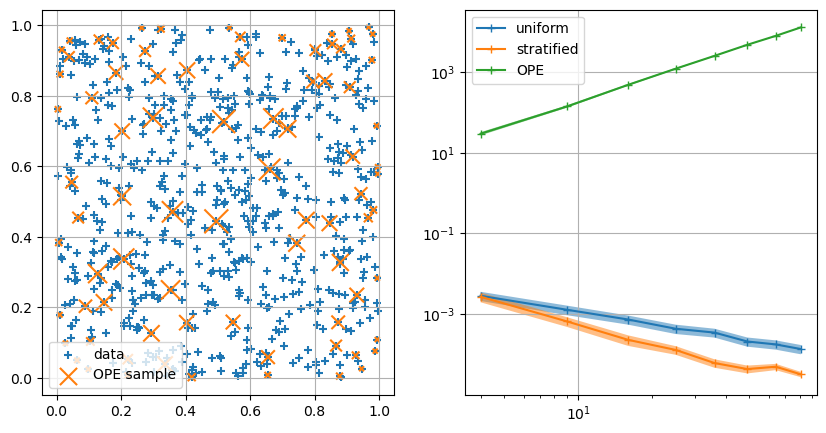

In [88]:
nb_stds = 5*n**(-.5)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], marker="+", label="data")
sample = DPP_samples[0]
plt.scatter(X[sample,0],X[sample,1], marker="x", label="OPE sample", s=10/diag_K_tilde[sample])
plt.legend(), plt.grid()

plt.subplot(122)
legends = ["uniform","stratified","OPE", 'OPE2', "OPE3", "OPE4"]
legends = ["uniform","stratified","OPE"]
plt.plot(ms[:,None], SE_means, label=legends, marker="+")
for k, legend in enumerate(legends):
    plt.fill_between(ms, SE_means[:,k]+nb_stds*SE_stds[:,k], SE_means[:,k]-nb_stds*SE_stds[:,k], alpha=.5)
plt.xscale('log'), plt.yscale('log'), plt.legend()
plt.grid(), plt.show();

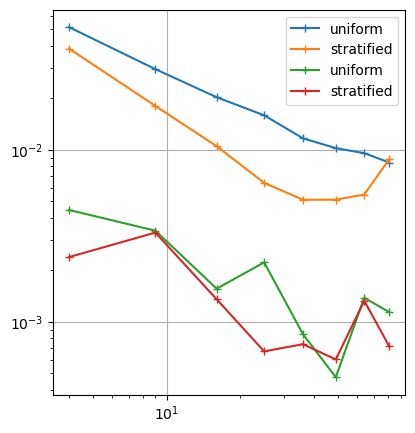

In [47]:

plt.figure(figsize=(10,5))
plt.subplot(121)
legends = ["uniform","stratified"]
plt.plot(ms[:,None], relerr_quant1[:,:2], label=legends, marker="+")
plt.plot(ms[:,None], relerr_quant2[:,:2], label=legends, marker="+")
plt.xscale('log'), plt.yscale('log'), plt.legend()
plt.grid(), plt.show();